### Import all relevant dependencies

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from pathlib import Path
import pandas as pd
import yaml
from src.visualization.plotting_functions import *
from src.utils.experiment_serialization import import_all_experiments, import_experiment_results
from src.model.parameter_set.hahn_parameter_set import HahnParameterSet
from src.math_utils.scaler.hahn_parameter_scaler import HahnParameterScaler

### Define the Experiment Metadata
- bounds for the free parameters
- operating conditions
- experiment repetitions
- true parameter set
- Experiment variance
- current values

Naming:
unscaled/ rescaled: actual physical values
scaled: scaled value between 0 & 1

In [2]:
path = "../data/config/reduced_example_config_workflow.yaml"

with open(path, "r") as f:
    config = yaml.safe_load(f)

n_rep = config["n_rep"]

# select parameter values and names to be analyzed
unscaled_theta_true = np.array([list(HahnParameterSet().free_parameters.values())[i] for i in [1, 2, 4]])
names_theta = [list(HahnParameterSet().free_parameters.keys())[i] for i in [1, 2, 4]]

# initialize lower and upper bounds for free parameter values
unscaled_upper_bounds_free_params = np.array(config["unscaled_upper_bounds_free_params"],dtype=float)
unscaled_lower_bounds_free_params = np.array(config["unscaled_lower_bounds_free_params"], dtype=float)

### Define Scaler and scale parameter values as well as  bounds of operating conditions and parameters
Scalers are saved in variable "scaler" and handed over to stack model.

In [3]:
scaler = HahnParameterScaler() # define scaler

# Stack bounds of free parameters
free_parameter_bounds = np.vstack([
    unscaled_lower_bounds_free_params,
    unscaled_upper_bounds_free_params
]).T

scaled_theta_true = scaler.scale_theta(unscaled_theta_true, free_parameter_bounds)

# scale bounds of free parameters for initializing Model
scaled_lower_bounds_theta, _ = scaler.scale(unscaled_lower_bounds_free_params, free_parameter_bounds)
scaled_upper_bounds_theta, _ = scaler.scale(unscaled_upper_bounds_free_params, free_parameter_bounds)

unit_factors = np.array([1e-4, 1e4, 1e4]) #[1e-3, 1e-4, 1e4, 1e4, 1e4, 1]) factors to reformat the units from SI to applicable industry standard units
crlb_factor = unscaled_upper_bounds_free_params-unscaled_lower_bounds_free_params

# Print scaling results of scaled true parameters
print("Scaled theta:", scaled_theta_true)
print("Rescaled theta:", unscaled_theta_true)

Scaled theta: [0.42501002 0.00327708 0.8474    ]
Rescaled theta: [2.1308e+03 4.2738e-06 8.6266e-06]


### Import LHC Designs

In [4]:
import_path = ".." / Path("data") / "experimental_designs" / "lhc"
df_exp_input = import_experiment_results(import_path/"lhc.csv")

# prepare LHC data for further analysis
x_designs = df_exp_input[['Pressure', 'Temperature', 'Stoichiometry', 'Current']].to_numpy()
y_designs = df_exp_input[['Voltage']].to_numpy()

# Import additional Experiments for optimality criteria

In [5]:
# Load all_additional experiments (LHC + others)
df_all = import_all_experiments(".." / Path("data") / "experimental_designs" / "other")
experiments = {name: group for name, group in df_all.groupby("SourceFile")}

# Designs singular with 5 additional Experiments
in total n_number_new_designs (default: 5) * n_current_values * n_rep = 5000

In [6]:
x_designs_all = {
    "LH_new": experiments["LH_new"][['Pressure','Temperature','Stoichiometry','Current']].to_numpy(),
    "a_design": experiments["a_design"][['Pressure','Temperature','Stoichiometry','Current']].to_numpy(),
    "d_design": experiments["d_design"][['Pressure','Temperature','Stoichiometry','Current']].to_numpy(),
    "pi_design": experiments["pi_design"][['Pressure','Temperature','Stoichiometry','Current']].to_numpy(),
}

y_designs_all = {
    "LH_new": experiments["LH_new"][['Voltage']].to_numpy(),
    "a_design": experiments["a_design"][['Voltage']].to_numpy(),
    "d_design": experiments["d_design"][['Voltage']].to_numpy(),
    "pi_design": experiments["pi_design"][['Voltage']].to_numpy(),
}

#### Stack Designs to form 25LHC+5OED Arrays

In [7]:
from src.utils.experiment_serialization import combine_experiments

cols_x = ['Pressure','Temperature','Stoichiometry','Current']
cols_y = ['Voltage']
design_names = ["LH_new", "a_design", "d_design", "pi_design"]

x_designs_all_stacked = {
    name: combine_experiments(x_designs, experiments[name][cols_x].to_numpy(), n_rep=n_rep)
    for name in design_names
}

y_designs_all_stacked = {
    name: combine_experiments(y_designs, experiments[name][cols_y].to_numpy().reshape(-1, 1), n_rep=n_rep)
    for name in design_names
}

#test print if the length of the experiment arrays is as expected. should be: (number_designs + n_new_designs) * n_current_values * n_rep
for k in x_designs_all_stacked:
    print(k, x_designs_all_stacked[k].shape, y_designs_all_stacked[k].shape)

LH_new (3100, 4) (3100, 1)
a_design (3100, 4) (3100, 1)
d_design (3100, 4) (3100, 1)
pi_design (3100, 4) (3100, 1)


# All Designs stacked with 25LH + 5 additional Experiments
in total (number_designs (default: 25) + n_number_new_designs (default: 5)) * n_current_values * n_rep = 30000

### Load Experiment results and theta estimations for Experiments from file

In [8]:
root = Path.cwd().parent   # oed_fuel_cell_model/
data_path = root / "data" / "experimental_designs" / "other"

# Load DataFrame
results_df = pd.read_pickle(data_path / "combined_experiments_results_df.pkl")

display(results_df)

,Experiment,FIM,det_FIM,diag_CRLB,CRLB,est_theta,var_theta,rel_std,rel_bias,rel_rmse,est_thetas
0,LH_new,"[[2864.795040710648, -598812.0361306258, 833.4...",4.021450e+13,"[0.0012999104074593423, 3.627173059366396e-08,...","[[0.0012999104074593423, 5.334714651523258e-06...","[0.42527442795828885, 0.0032833514283149203, 0...","[0.001497813683983358, 4.4696891749849874e-08,...","[0.084778834413651, 0.05800517872958845, 0.070...","[0.0006221216106474561, 0.001914618146070686, ...","[0.09060612619449071, 0.0642188766660859, 0.07...","[[0.3554081188587537, 0.0029519900053959127, 0..."
1,a_design,"[[2828.6248528673564, -583829.4566027612, 3434...",1.214298e+16,"[0.0012280270541661826, 2.1415397514130306e-08...","[[0.0012280270541661826, 4.287696511063816e-06...","[0.4253018577284241, 0.0032781392297826623, 0....","[0.0015605786941142803, 2.245182193824259e-08,...","[0.08239610599544164, 0.04464118095121685, 0.0...","[0.000686660724649215, 0.00032411587539876057,...","[0.09248541191351804, 0.04549542820877882, 0.0...","[[0.4198008851876337, 0.003282349879164864, 0...."
2,d_design,"[[2830.632432411114, -572723.2524830349, 5594....",1.726702e+16,"[0.0012458977319899122, 2.40264373542527e-08, ...","[[0.0012458977319899122, 4.561368715595638e-06...","[0.4224156858452841, 0.003268697119393813, 0.8...","[0.0014596007835700555, 2.589782620539916e-08,...","[0.08356052517649641, 0.047420923657197175, 0....","[-0.006104171837057967, -0.002557143907868509,...","[0.08964881561361092, 0.04892789604903872, 0.0...","[[0.33688869190687065, 0.002988158477251917, 0..."
3,pi_design,"[[2756.765436747533, -558888.5482185334, 2235....",3.349196e+15,"[0.0012267364458960841, 2.1639927270672284e-08...","[[0.0012267364458960841, 4.26091107601781e-06,...","[0.4253212785485047, 0.0032825575804956903, 0....","[0.0014485344282663512, 2.5067552024373313e-08...","[0.08234903672089589, 0.04481418941739674, 0.0...","[0.0007323556945672779, 0.0016723755010066147,...","[0.08910406322451778, 0.04810049641478231, 0.0...","[[0.37557486530498135, 0.003069544739596749, 0..."


### Evaluate results


#### Print overall metrics
Only to compare the different design approaches

In [9]:
n_params = results_df["est_theta"].iloc[0].size  # Amount of Parameters

theta_df_new = pd.DataFrame({
    "Design": results_df["Experiment"].tolist(),
    **{f"θ_{i+1}": [row[i] for row in results_df["est_theta"]] for i in range(n_params)},
    **{f"σ_rel(θ_{i+1})": [row[i] for row in results_df["rel_rmse"]] for i in range(n_params)},
    **{f"CRLB(θ_{i+1})": [row[i] for row in results_df["diag_CRLB"]] for i in range(n_params)},
})

display(theta_df_new)

,Design,θ_1,θ_2,θ_3,σ_rel(θ_1),σ_rel(θ_2),σ_rel(θ_3),CRLB(θ_1),CRLB(θ_2),CRLB(θ_3)
0,LH_new,0.425274,0.003283,0.857829,0.090606,0.064219,0.071321,0.001300,3.627173e-08,0.003609
1,a_design,0.425302,0.003278,0.847475,0.092485,0.045495,0.003624,0.001228,2.141540e-08,0.000011
2,d_design,0.422416,0.003269,0.847239,0.089649,0.048928,0.003574,0.001246,2.402644e-08,0.000008
3,pi_design,0.425321,0.003283,0.847805,0.089104,0.048100,0.007699,0.001227,2.163993e-08,0.000039


#### Write corresponding theta estimates and CRLB into arrays

In [10]:
# Make a 2D array: rows = designs, columns = parameters
design_names = ["LH_new", "a_design", "d_design", "pi_design"]

# Collect estimated thetas from results_df
scaled_estimated_thetas = np.array([
    results_df.loc[results_df["Experiment"] == name, "est_thetas"].values[0]
    for name in design_names
])

# Collect CRLB diagonals from results_df
diagonal_CRLB_experiment = np.array([
    results_df.loc[results_df["Experiment"] == name, "diag_CRLB"].values[0]
    for name in design_names
])

#### Plot all arrays for all experiments

In [11]:
for i, name in enumerate(design_names):

    print(name)
    print(50* "=")

    raw_estimated_thetas = [scaler.rescale_theta(np.array(theta, dtype=float)) for theta in scaled_estimated_thetas[i]]

    crlb = diagonal_CRLB_experiment[i]*crlb_factor*crlb_factor*unit_factors*unit_factors

    print("Unit factors:", unit_factors)

    print("scaled CRLB:", diagonal_CRLB_experiment[i])
    print("unscaled CRLB SI:", diagonal_CRLB_experiment[i]*crlb_factor*crlb_factor)
    print("unscaled CRLB Industry Units:", crlb)

    print("scaled estimated Theta:", np.mean(scaled_estimated_thetas[i], axis=0))
    print("unscaled estimated Theta SI:", np.mean(raw_estimated_thetas, axis=0))
    print("unscaled estimated Theta Industry Units:", np.mean(raw_estimated_thetas, axis=0)*unit_factors)

    print("scaled true Theta:", scaled_theta_true)
    print("unscaled true Theta SI:", unscaled_theta_true)
    print("unscaled true Theta Industry Units:", unscaled_theta_true*unit_factors)

    scaled_rel_std = np.sqrt(diagonal_CRLB_experiment[i])/np.abs(scaled_theta_true)
    print("scaled relative std", scaled_rel_std)

    rescaled_rel_std = np.sqrt(crlb)/np.abs(unscaled_theta_true*unit_factors)
    print("unscaled relative std industry units", rescaled_rel_std)

    rescaled_rel_std = np.sqrt(diagonal_CRLB_experiment[i]*crlb_factor*crlb_factor)/np.abs(unscaled_theta_true)
    print("unscaled relative std SI", rescaled_rel_std)

    print(50* "=")

LH_new
Unit factors: [1.e-04 1.e+04 1.e+04]
scaled CRLB: [1.29991041e-03 3.62717306e-08 3.60854225e-03]
unscaled CRLB SI: [3.23678991e+04 3.61992234e-14 2.92291922e-13]
unscaled CRLB Industry Units: [3.23678991e-04 3.61992234e-06 2.92291922e-05]
scaled estimated Theta: [0.42527443 0.00328335 0.8578292 ]
unscaled estimated Theta SI: [2.13211940e+03 4.28006808e-06 8.72046280e-06]
unscaled estimated Theta Industry Units: [0.21321194 0.04280068 0.08720463]
scaled true Theta: [0.42501002 0.00327708 0.8474    ]
unscaled true Theta SI: [2.1308e+03 4.2738e-06 8.6266e-06]
unscaled true Theta Industry Units: [0.21308  0.042738 0.086266]
scaled relative std [0.08483158 0.05811624 0.07088877]
unscaled relative std industry units [0.08443346 0.04451798 0.06267131]
unscaled relative std SI [0.08443346 0.04451798 0.06267131]
a_design
Unit factors: [1.e-04 1.e+04 1.e+04]
scaled CRLB: [1.22802705e-03 2.14153975e-08 1.14330874e-05]
unscaled CRLB SI: [3.05779965e+04 2.13725881e-14 9.26080078e-16]
unscale

LH_new


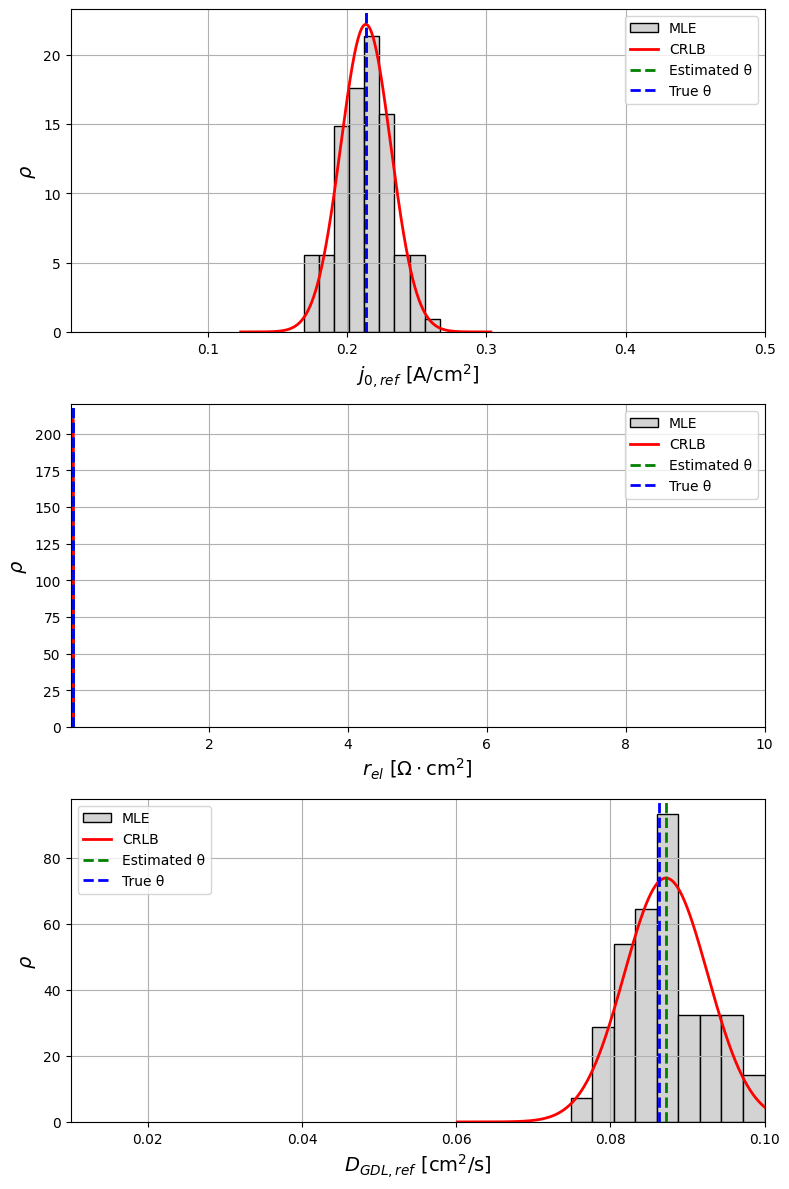

a_design


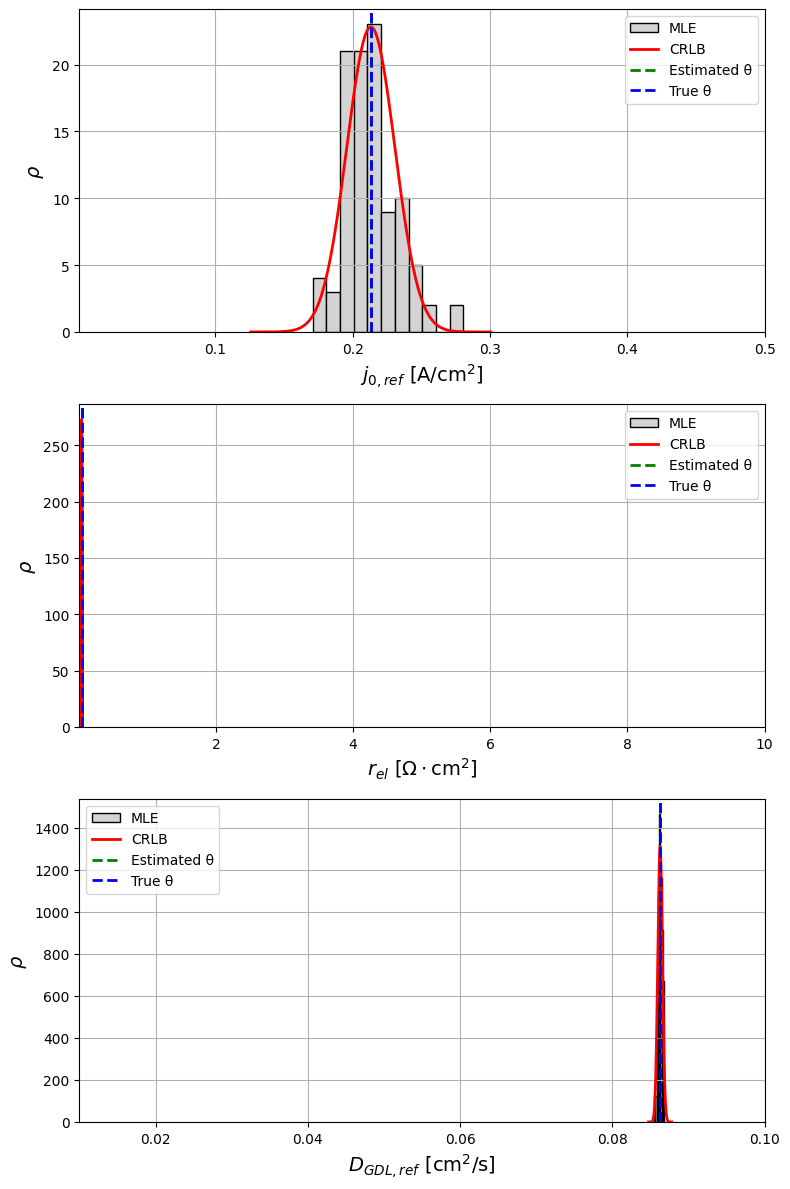

d_design


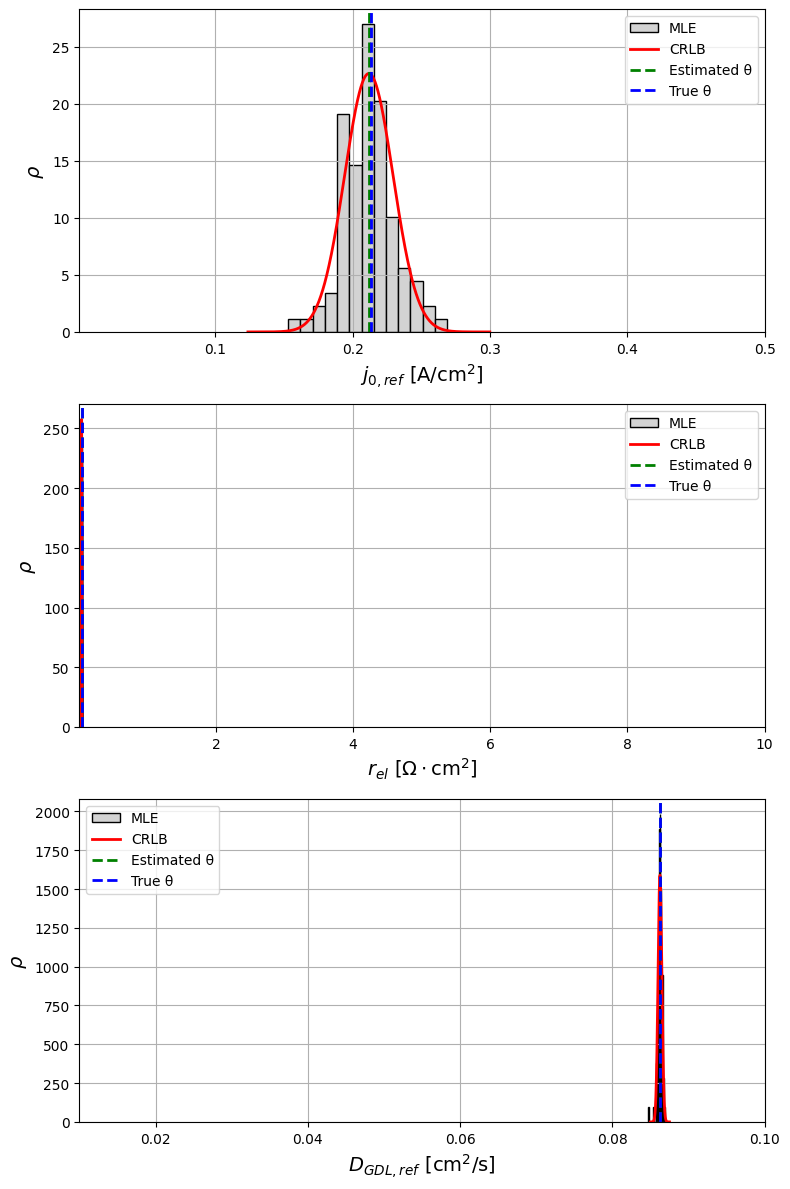

pi_design


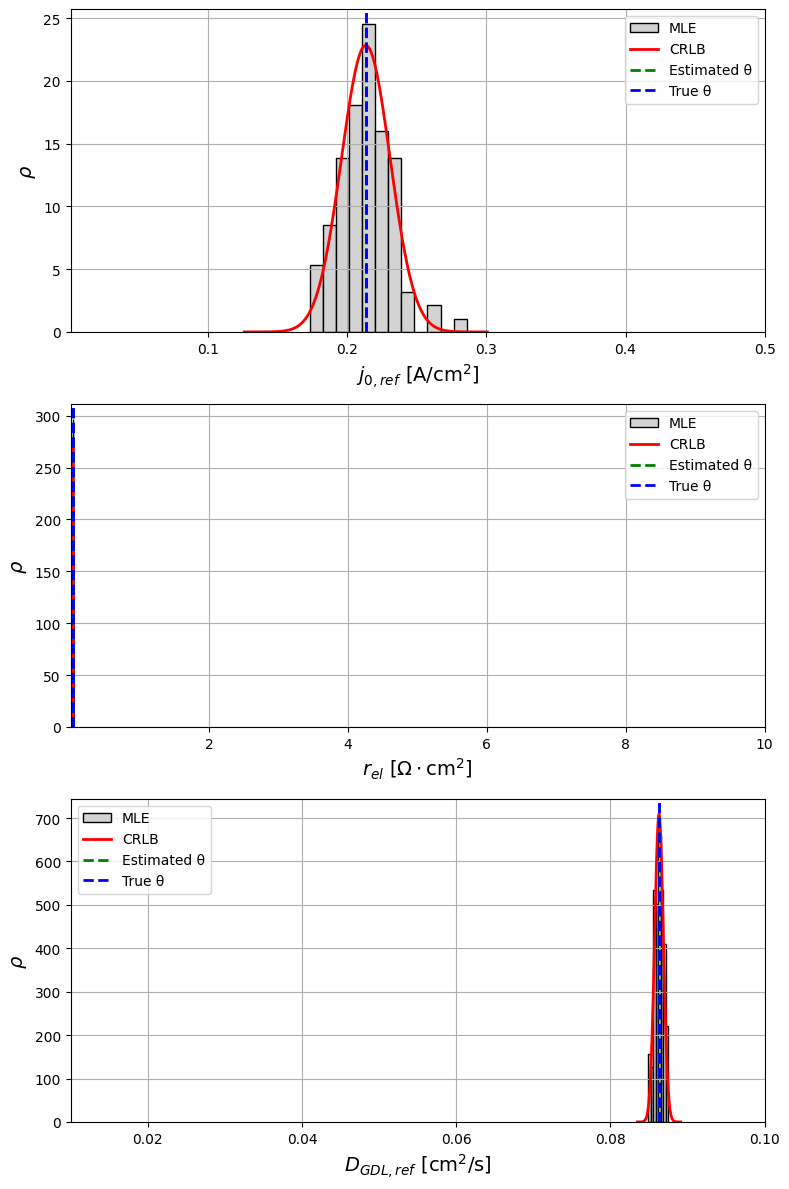

In [13]:
parameter_names = [r'$j_{0,ref}~\mathrm{[A/cm^2]}$', r"$r_{el}~\mathrm{[\Omega\cdot cm^2]}$", r"$D_{GDL,ref}~\mathrm{[cm^2/s]}$"]

for i, name in enumerate(design_names):

    print(name)
    print(50* "=")

    raw_estimated_thetas = [scaler.rescale_theta(np.array(theta, dtype=float)) for theta in scaled_estimated_thetas[i]]

    crlb = diagonal_CRLB_experiment[i]*crlb_factor*crlb_factor*unit_factors*unit_factors

    plot_mle_vs_crlb(
        raw_estimated_thetas*unit_factors,  # <== this should be the MLE estimates!
        crlb,  # <== this should be the CRLB variances!
        unscaled_theta_true*unit_factors,
        unscaled_lower_bounds_free_params*unit_factors,
        unscaled_upper_bounds_free_params*unit_factors,
        param_names=parameter_names,
    )

    print(50* "=")